# AI & DL

## Лабораторная работа №3

### Выполнил: Инютин М. А.
### Группа: М8О-407Б-19

Необходимые библиотеки для анализы данных

In [1]:
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

## Часть 1

Набор данных - [Steel Industry Energy Consumption](https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption)

### Обработка входных данных

In [3]:
ds = pd.read_csv("../data/Steel_industry_data.csv")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [4]:
ds = ds.rename(columns = {
    "Lagging_Current_Reactive.Power_kVarh" : "LagCRP",
    "Leading_Current_Reactive_Power_kVarh" : "LeaCRP",
    "Lagging_Current_Power_Factor" : "LagCPF",
    "Leading_Current_Power_Factor" : "LeaCPF",
    "Day_of_week" : "Day"
})
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        35040 non-null  object 
 1   Usage_kWh   35040 non-null  float64
 2   LagCRP      35040 non-null  float64
 3   LeaCRP      35040 non-null  float64
 4   CO2(tCO2)   35040 non-null  float64
 5   LagCPF      35040 non-null  float64
 6   LeaCPF      35040 non-null  float64
 7   NSM         35040 non-null  int64  
 8   WeekStatus  35040 non-null  object 
 9   Day         35040 non-null  object 
 10  Load_Type   35040 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 2.9+ MB


In [5]:
ds = ds.drop("date", axis = "columns")

In [6]:
ds_Day = pd.get_dummies(ds.Day)
ds_Load_Type = pd.get_dummies(ds.Load_Type)

ds_categorical = pd.concat([ds_Day, ds_Load_Type], axis = "columns")
ds_categorical.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Load,Maximum_Load,Medium_Load
0,0,1,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0


In [7]:
ds["WeekStatus"].replace(["Weekday", "Weekend"],
                         [0, 1], inplace = True)
ds = ds.drop("Day", axis = "columns")
ds = ds.drop("Load_Type", axis = "columns")

ds = pd.concat([ds, ds_categorical], axis = "columns")
ds.head()

,Usage_kWh,LagCRP,LeaCRP,CO2(tCO2),LagCPF,LeaCPF,NSM,WeekStatus,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Load,Maximum_Load,Medium_Load
0,3.17,2.95,0.0,0.0,73.21,100.0,900,0,0,1,0,0,0,0,0,1,0,0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,0,0,1,0,0,0,0,0,1,0,0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,0,0,1,0,0,0,0,0,1,0,0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,0,0,1,0,0,0,0,0,1,0,0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,0,0,1,0,0,0,0,0,1,0,0


In [8]:
def scores_regr(model, X, y):
    print("Лучшие гиперпараметры модели:", model.best_params_)
    print("Лучший счёт модели:", model.best_score_)
    pred = model.best_estimator_.predict(X)
    print("Метрика MSE:", mean_squared_error(y, pred))
    print("Метрика MAE:", mean_absolute_error(y, pred))

Так как обучение на всём датасете очень долгое, беру только его часть

In [9]:
remove_n = 30000
drop_indices = np.random.choice(ds.index, remove_n, replace = False)
ds = ds.drop(drop_indices)

In [10]:
X = ds.drop("Usage_kWh", axis = 1).to_numpy()
y = ds["Usage_kWh"].to_numpy()

print("Размерность входных данных:", X.shape)
print("Размерность выходных данных:", y.shape)

Размерность входных данных: (5040, 17)
Размерность выходных данных: (5040,)


In [11]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

print("Размерность тренировочных входных данных:", train_X.shape)
print("Размерность тренировочных выходных данных:", train_y.shape)

print("Размерность тестовых входных данных:", test_X.shape)
print("Размерность тестовых выходных данных:", test_y.shape)

Размерность тренировочных входных данных: (4032, 17)
Размерность тренировочных выходных данных: (4032,)
Размерность тестовых входных данных: (1008, 17)
Размерность тестовых выходных данных: (1008,)


### Решающее дерево для линейной регрессии

Хранение данных в вершине дерева. Хранится предикат $X_{ind} \ge value$, если вершина не лист, иначе значение $value$

In [12]:
class TreeData():
    def __init__(self, value = None, ind = None, leaf = True):
        self.value = value
        self.ind = ind
        self.leaf = leaf
    
    def is_leaf(self):
        return self.leaf
    
    def decide(self, X):
        if (self.is_leaf()):
            return None
        else:
            return True if (X[self.ind] >= self.value) else False
    
    def predict(self, X):
        if (self.is_leaf()):
            return value
        else:
            return None

Класс для хранения дерева. Реализован как список смежности

In [13]:
class Graph:
    def __init__(self):
        self.data = []
        self.info = []
        self.size = 0
        self.add()
    
    def can_go(self, u, c):
        return c in self.data[u]
    
    def go(self, u, c):
        return self.data[u][c]
    
    def set_go(self, u, c, v):
        self.data[u][c] = v

    def get_tree_data(self, u):
        return self.info[u]
    
    def set_tree_data(self, u, tree_data):
        self.info[u] = tree_data
    
    def add(self):
        self.data.append(dict())
        self.info.append(TreeData())
        self.size += 1
        return self.size - 1

    def is_leaf(self, u):
        return self.info[u].is_leaf()

Решающее дерево

In [14]:
class DecisionTree:
    def __init__(self, max_depth, min_count, rnd_split):
        self.tree = Graph()
        self.max_depth = max_depth
        self.min_count = min_count
        self.rnd_split = rnd_split
        self.data = []
        self.INF = 1e18
        self.EPS = 1e-6
        
    def leq(self, x, y):
        return (x < y) or np.abs(x - y) < self.EPS
        
    def decide(self, X):
        return self.decide_rec(0, X)
    
    def decide_rec(self, u, X):
        u_data = self.tree.get_tree_data(u)
        if (self.tree.is_leaf(u)):
            return u_data.value
        else:
            dec = u_data.decide(X)
            return self.decide_rec(self.tree.go(u, dec), X)
    
    def make_leaf(self, u, value):
        u_data = TreeData(value = value, leaf = True)
        self.tree.set_tree_data(u, u_data)
    
    # Генерирует случайные индексы без повторений
    def rnd_ids(self, n):
        res = []
        while (len(res) * len(res) < n):
            rnd_num = randint(0, n - 1)
            while (rnd_num in res):
                rnd_num = randint(0, n - 1)
            res.append(rnd_num)
        return res
    
    def build(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.d = X.shape[1]
        ids = np.arange(self.n)
        self.build_rec(0, ids, 1)
    
    def build_rec(self, u, ids, h):
        n = len(ids)
        mn_val = self.INF
        mx_val = -self.INF
        u_val = 0
        for j in ids:
            mn_val = min(self.y[j], mn_val)
            mx_val = max(self.y[j], mx_val)
            u_val += self.y[j]
        u_val /= n
        stop1 = (n <= self.min_count)
        stop2 = (h > self.max_depth)
        stop3 = (np.abs(mn_val - mx_val) < self.EPS)
        if (stop1 or stop2 or stop3):
            self.make_leaf(u, u_val)
            return
        min_loss = self.INF
        res = (-1, -1)
        u_data = self.tree.get_tree_data(u)
        split_ids = (self.rnd_ids(self.d) if self.rnd_split else range(self.d))
        for i in split_ids:
            tmp = []
            for j in ids:
                tmp.append((self.X[j][i], self.y[j]))
            tmp = sorted(tmp)
            size_l = 0
            size_r = n
            sum_l = 0
            sum_sq_l = 0
            sum_y = 0
            sum_sq_y = 0
            for j in ids:
                y = self.y[j]
                sum_y += y
                sum_sq_y += y ** 2
            for j in range(self.n):
                while (size_l < n and self.leq(tmp[size_l][0], tmp[j][0])):
                    sum_l += tmp[size_l][1]
                    sum_sq_l += tmp[size_l][1] ** 2
                    size_l += 1
                size_r = n - size_l
                if (size_l == 0 or size_r == 0):
                    continue
                sum_r = sum_y - sum_l
                sum_sq_r = sum_sq_y - sum_sq_l
                avg_l = sum_l / size_l
                avg_r = sum_r / size_r
                
                loss_l = (sum_sq_l - 2 * avg_l * sum_l + size_l * avg_l ** 2) / size_l
                loss_r = (sum_sq_r - 2 * avg_r * sum_r + size_r * avg_r ** 2) / size_r
                
                split_loss = loss_l + loss_r
                if (split_loss < min_loss):
                    min_loss = split_loss
                    res = (i, tmp[j][0])
        if (res == (-1, -1)):
            self.make_leaf(u, u_val)
            return
        u_data = TreeData(value = res[1], ind = res[0], leaf = False)
        self.tree.set_tree_data(u, u_data)
        l, r = [], []
        for j in ids:
            if (u_data.decide(self.X[j])):
                l.append(j)
            else:
                r.append(j)
        if (len(l) == 0 or len(r) == 0):
            self.make_leaf(u, u_val)
            return
        ul = self.tree.add()
        ur = self.tree.add()
        self.tree.set_go(u, True, ul)
        self.tree.set_go(u, False, ur)
        self.build_rec(ul, np.array(l), h + 1)
        self.build_rec(ur, np.array(r), h + 1)

Регрессор

In [15]:
class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, max_depth = 10, min_count = 50, rnd_split = False):
        self.max_depth = max_depth
        self.min_count = min_count
        self.rnd_split = rnd_split
        self.tree = DecisionTree(max_depth, min_count, rnd_split)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        self.tree.build(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        return np.array([self.tree.decide(elem) for elem in X])

### Случайный лес

In [16]:
class MyRandomForestRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, n_trees = 10, max_depth = 2, min_count = 5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_count = min_count
        self.trees = [MyDecisionTreeRegressor(max_depth, min_count, rnd_split = True) for _ in range(self.n_trees)]

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        n = len(X)
        for (i, tree) in enumerate(self.trees):
            rnd_ids = np.random.choice(n, (2 * n) // self.n_trees)
            X_sub = X[rnd_ids]
            y_sub = y[rnd_ids]
            tree.fit(X_sub, y_sub)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        res = []
        for tree in self.trees:
            res.append(tree.predict(X))
        res = np.array(res)
        return np.mean(res, axis = 0)

In [17]:
gscv_dtr = GridSearchCV(Pipeline([("dtr", MyDecisionTreeRegressor())]),
                    {"dtr__max_depth" : [8, 16, 32],
                     "dtr__min_count" : [50, 100, 200]})
gscv_dtr.fit(train_X, train_y)
scores_regr(gscv_dtr, test_X, test_y)

Лучшие гиперпараметры модели: {'dtr__max_depth': 8, 'dtr__min_count': 50}
Лучший счёт модели: 0.8837712636421935
Метрика MSE: 121.9824579426967
Метрика MAE: 6.157324210641027


In [18]:
gscv_rfr = GridSearchCV(Pipeline([("rfr", MyRandomForestRegressor())]),
                    {"rfr__n_trees" : [10, 25, 50],
                     "rfr__max_depth" : [2, 3, 4],
                     "rfr__min_count" : [2, 5, 10]})
gscv_rfr.fit(train_X, train_y)
scores_regr(gscv_rfr, test_X, test_y)

Лучшие гиперпараметры модели: {'rfr__max_depth': 2, 'rfr__min_count': 10, 'rfr__n_trees': 25}
Лучший счёт модели: 0.7260201008664521
Метрика MSE: 294.4386497799741
Метрика MAE: 11.896685631827138


Дерево принятия решений - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [19]:
gscv_dtr = RandomizedSearchCV(Pipeline([("dcr", DecisionTreeRegressor())]),
                    {"dcr__criterion" : ["squared_error", "friedman_mse", "poisson"],
                     "dcr__splitter" : ["best", "random"],
                     "dcr__max_depth" : [8, 16, 32],
                     "dcr__min_samples_split" : [50, 100, 200]})
gscv_dtr.fit(train_X, train_y)
scores_regr(gscv_dtr, test_X, test_y)

Лучшие гиперпараметры модели: {'dcr__splitter': 'best', 'dcr__min_samples_split': 50, 'dcr__max_depth': 16, 'dcr__criterion': 'squared_error'}
Лучший счёт модели: 0.9861557417623473
Метрика MSE: 11.51168716241671
Метрика MAE: 1.6779966122566103


Случайный лес - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [20]:
rfr_model = RandomizedSearchCV(Pipeline([("rfr", RandomForestRegressor())]),
                    {"rfr__n_estimators" : [25, 50, 100],
                     "rfr__criterion" : ["squared_error", "friedman_mse", "poisson"],
                     "rfr__max_depth" : [2, 3, 4]})
rfr_model.fit(train_X, train_y)
scores_regr(rfr_model, test_X, test_y)

Лучшие гиперпараметры модели: {'rfr__n_estimators': 100, 'rfr__max_depth': 4, 'rfr__criterion': 'squared_error'}
Лучший счёт модели: 0.9832057248396943
Метрика MSE: 18.508024939426246
Метрика MAE: 2.416693644843618


Реализация дерева получилась близкая по результатам к sklearn, а случайные лес хуже

## Часть 2

Набор данных - [Machine Predictive Maintenance Classification](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification)

### Обработка входных данных

Вспомогательная функция для построения гистограмм

In [21]:
def gist(ds, n, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize = (20, 10))
    fig.suptitle("Распределения числовых признаков")
    for i in range(n):
        sns.histplot(ds[ds.columns[i]], ax = ax[i // cols][i % cols], kde = True)
    pass

In [22]:
ds = pd.read_csv("../data/predictive_maintenance.csv")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Убираю столбец с уникальными идентификаторами ```UDI```

Столбец ```Product ID``` содержит качество оборудования, которое так же выписано в столбце ```Type```, поэтому также ```Product ID``` можно удалить.

In [23]:
ds = ds.drop("UDI", axis = "columns")
ds = ds.drop("Product ID", axis = "columns")

Можно решать две задачи:

* Бинарная классификация по столбцу ```Target``` - определить, будет ли поломка;
* Многоклассовая классификация по столбцу ```Failure Type``` - определить тип поломки.

Удаляю столбец ```Target```, чтобы не было утечки информации.

In [24]:
ds = ds.drop("Target", axis = "columns")

Переименую столбцы для лучшего восприятия таблицы

In [25]:
ds = ds.rename(columns = {
    "Air temperature [K]" : "Air temp",
    "Process temperature [K]" : "Process temp",
    "Rotational speed [rpm]" : "RPM",
    "Torque [Nm]" : "Torque",
    "Tool wear [min]" : "Wear",
    "Failure Type" : "Failure"
})
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Type          10000 non-null  object 
 1   Air temp      10000 non-null  float64
 2   Process temp  10000 non-null  float64
 3   RPM           10000 non-null  int64  
 4   Torque        10000 non-null  float64
 5   Wear          10000 non-null  int64  
 6   Failure       10000 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 547.0+ KB


Пример данных

In [26]:
ds.head()

,Type,Air temp,Process temp,RPM,Torque,Wear,Failure
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


In [27]:
ds.isna().sum()

Type            0
Air temp        0
Process temp    0
RPM             0
Torque          0
Wear            0
Failure         0
dtype: int64

Пропусков нет, обработка не требуется

In [28]:
# ds = ds.dropna()

Парные графики числовых признаков

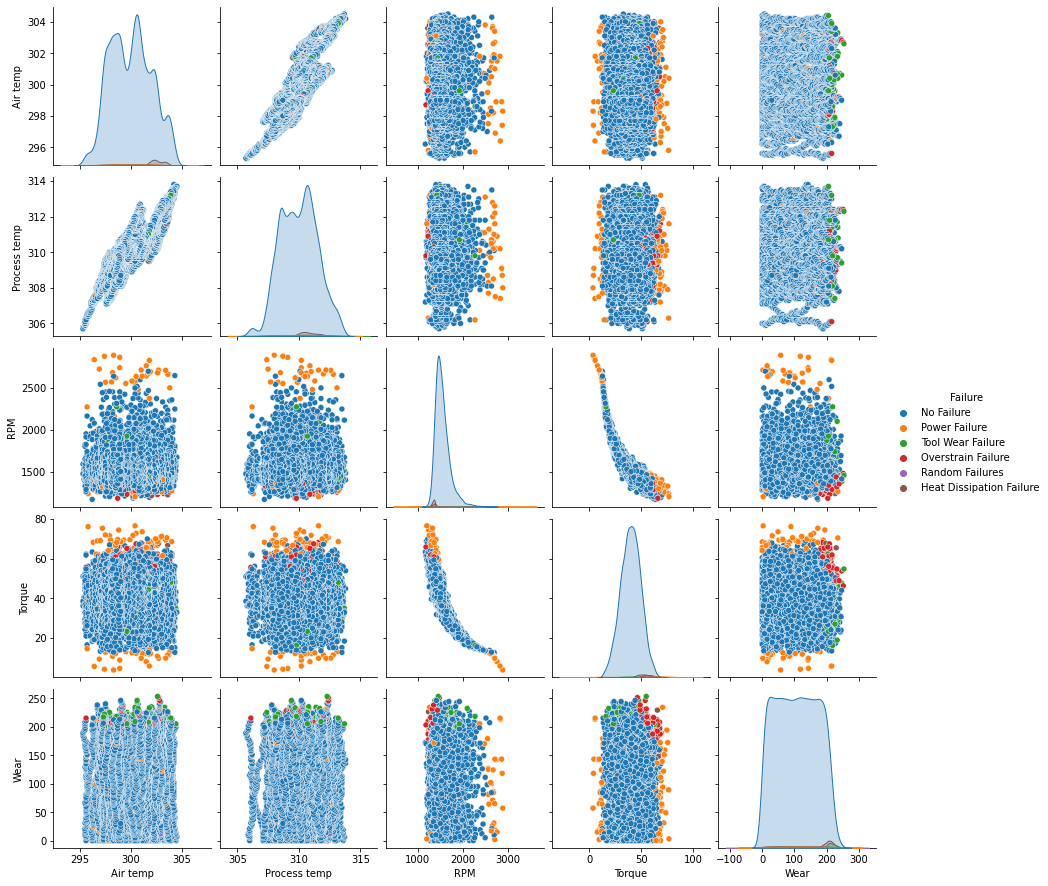

In [29]:
sns.pairplot(data = ds, hue = "Failure")
pass

**Видно, что некоторые классы находятся по краям облаков, а другие внутри. Может получится не самый высокий результат**

One-Hot Encoding категориальных признаков

In [30]:
ds_Type = pd.get_dummies(ds.Type)
ds_Type.head()

,H,L,M
0,0,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


Заменяю категориальные признаки числовыми

In [31]:
ds = ds.drop("Type", axis = "columns")
ds = pd.concat([ds, ds_Type], axis = "columns")
ds.head()

,Air temp,Process temp,RPM,Torque,Wear,Failure,H,L,M
0,298.1,308.6,1551,42.8,0,No Failure,0,0,1
1,298.2,308.7,1408,46.3,3,No Failure,0,1,0
2,298.1,308.5,1498,49.4,5,No Failure,0,1,0
3,298.2,308.6,1433,39.5,7,No Failure,0,1,0
4,298.2,308.7,1408,40.0,9,No Failure,0,1,0


Кодирую класс числом

In [32]:
targets = set(ds["Failure"].astype("category").cat.categories)

sorted_targets = sorted([elem for elem in targets])

ds["Failure"].replace(sorted_targets,
                      [1, 0, 2, 3, 4, 5],
                      inplace=True)

ds.head()

,Air temp,Process temp,RPM,Torque,Wear,Failure,H,L,M
0,298.1,308.6,1551,42.8,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,1,0


In [33]:
ds = ds.convert_dtypes()
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Air temp      10000 non-null  Float64
 1   Process temp  10000 non-null  Float64
 2   RPM           10000 non-null  Int64  
 3   Torque        10000 non-null  Float64
 4   Wear          10000 non-null  Int64  
 5   Failure       10000 non-null  Int64  
 6   H             10000 non-null  UInt8  
 7   L             10000 non-null  UInt8  
 8   M             10000 non-null  UInt8  
dtypes: Float64(3), Int64(3), UInt8(3)
memory usage: 586.1 KB


Матрица корреляции признаков

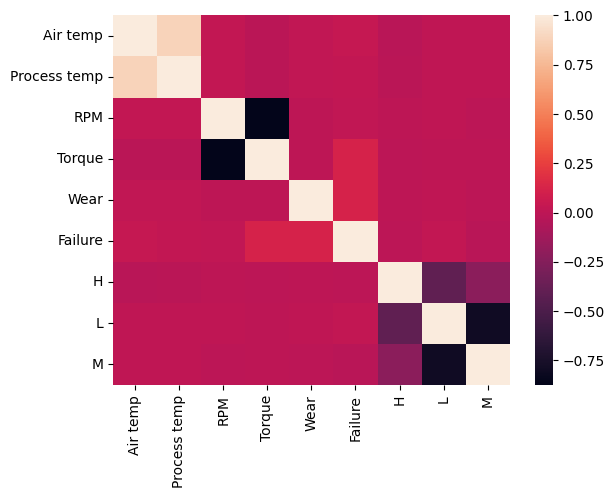

In [34]:
sns.heatmap(ds.corr())
pass

**Полной корреляции нет, удаление признаков не требуется**

Гистограммы числовых признаков

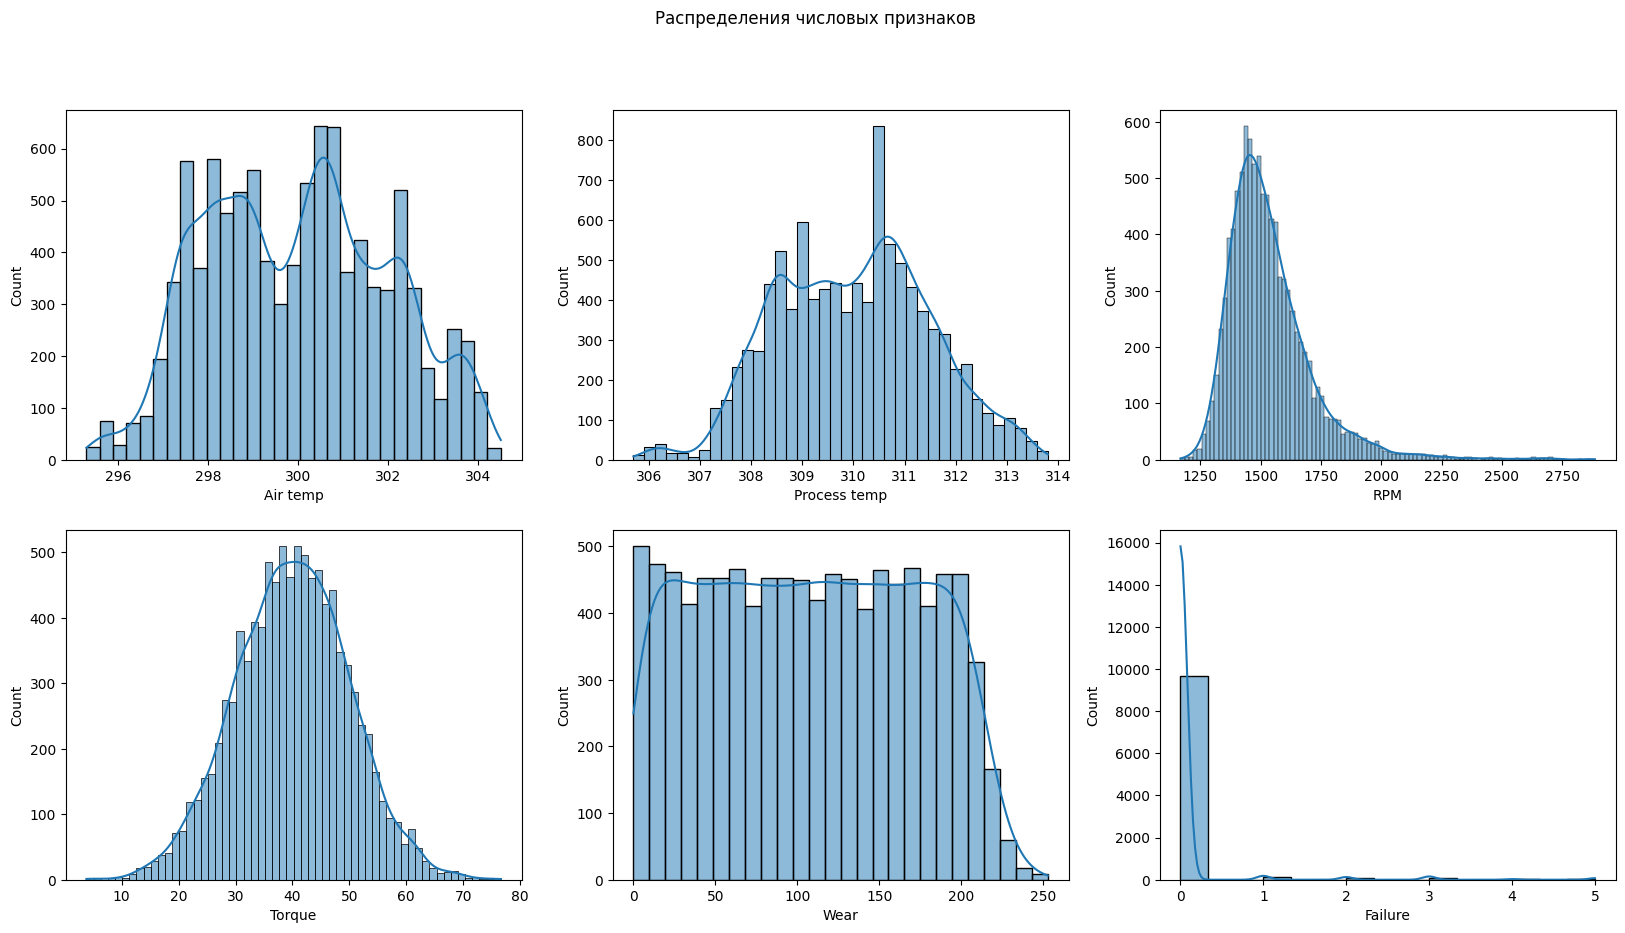

In [35]:
gist(ds, 6, 2, 3)

Выбросов в числовых признаках нет. Есть сильный перевес классов, использую downsampling.

In [36]:
ds_no_fail = ds[ds["Failure"] == 0]
ds_fail = ds[ds["Failure"] != 0]

COEF_UNDER = 2

down_ds_no_fail = ds_no_fail.sample(n = len(ds_fail) // COEF_UNDER, random_state = 1)

COEF_UPPER = 1
ds = pd.concat([down_ds_no_fail, ds_fail, ds_fail])
for _ in range(COEF_UPPER - 1):
    ds = pd.concat([ds, ds_fail])

ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 1307 to 9974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Air temp      870 non-null    Float64
 1   Process temp  870 non-null    Float64
 2   RPM           870 non-null    Int64  
 3   Torque        870 non-null    Float64
 4   Wear          870 non-null    Int64  
 5   Failure       870 non-null    Int64  
 6   H             870 non-null    UInt8  
 7   L             870 non-null    UInt8  
 8   M             870 non-null    UInt8  
dtypes: Float64(3), Int64(3), UInt8(3)
memory usage: 57.8 KB


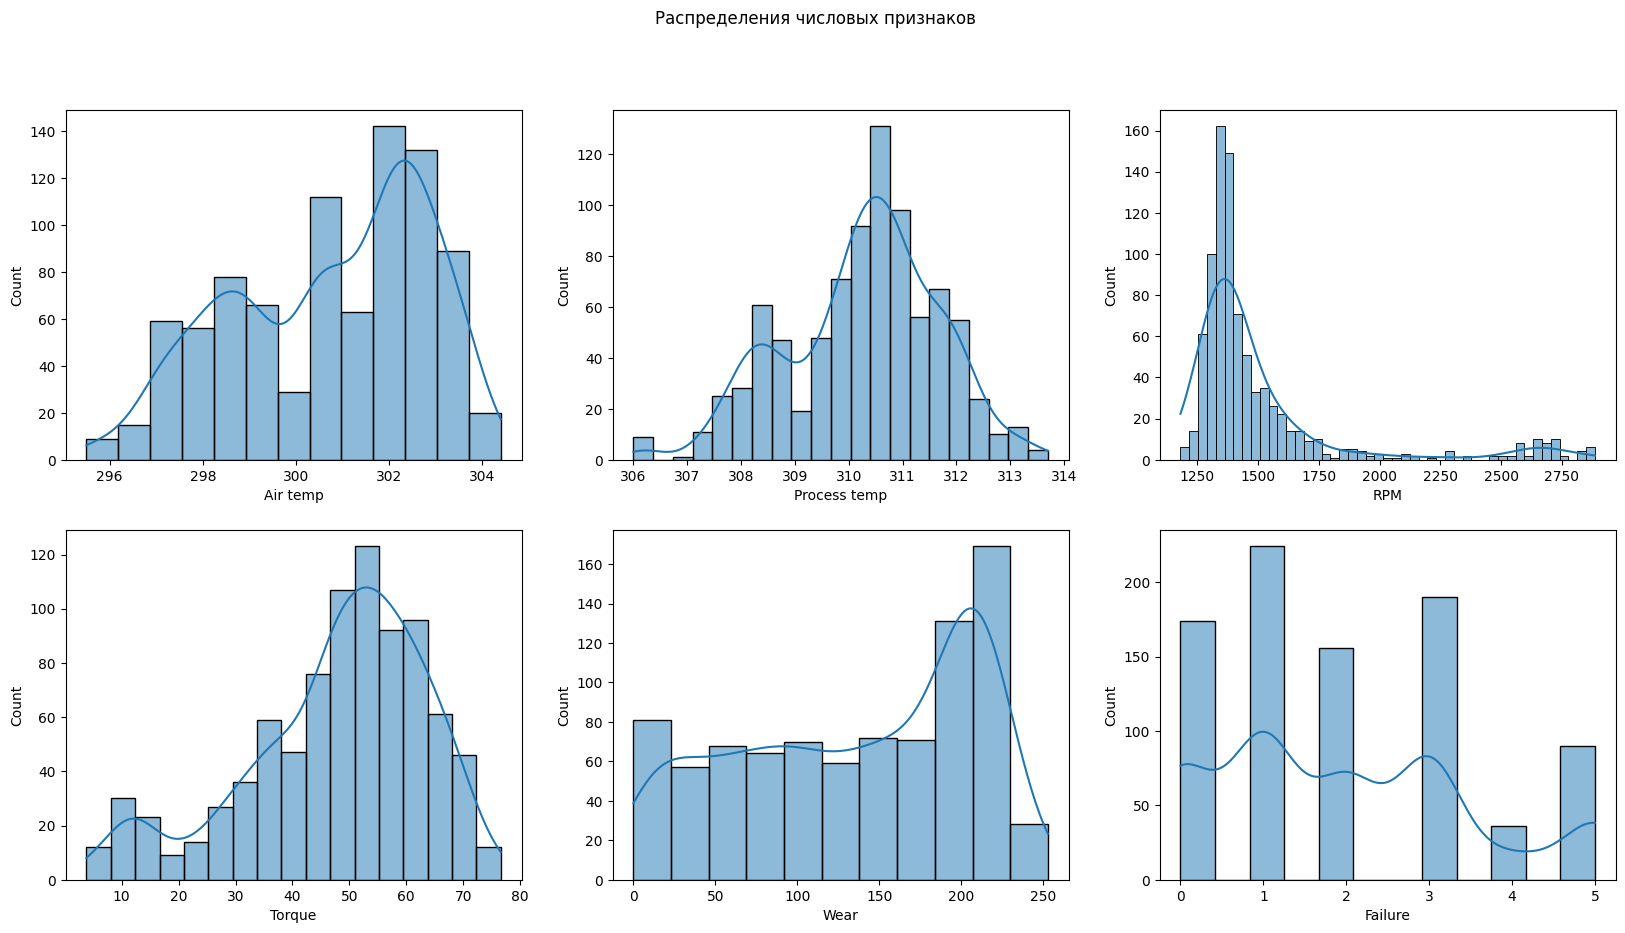

In [37]:
gist(ds, 6, 2, 3)

**Данные подготовлены для обучения модели**

### Обучение модели

Функция для вывода результатов обучения

In [38]:
def scores(model, X, y):
    print("Лучшие гиперпараметры модели:", model.best_params_)
    print("Лучший счёт модели:", model.best_score_)
    pred = model.best_estimator_.predict(X)
    print("Метрика Accuracy:", accuracy_score(y, pred))
    
    figure = plt.figure(figsize = (16, 8))
    ax = plt.subplot(1, 1, 1)
    matr = confusion_matrix(y, pred)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    plt.show()

Разбиваю данные на признаки и то, что требуется предсказать

In [39]:
X = ds.drop("Failure", axis = 1).to_numpy(dtype = np.float64)
y = ds["Failure"].to_numpy(dtype = np.int32)

print("Размерность входных данных:", X.shape)
print("Размерность выходных данных:", y.shape)

Размерность входных данных: (870, 8)
Размерность выходных данных: (870,)


Пример данных

In [40]:
X[:5]

array([[2.988e+02, 3.100e+02, 1.423e+03, 4.210e+01, 1.540e+02, 0.000e+00,
        1.000e+00, 0.000e+00],
       [2.981e+02, 3.087e+02, 1.527e+03, 4.300e+01, 5.600e+01, 0.000e+00,
        0.000e+00, 1.000e+00],
       [2.988e+02, 3.097e+02, 1.529e+03, 4.400e+01, 1.360e+02, 0.000e+00,
        1.000e+00, 0.000e+00],
       [3.041e+02, 3.133e+02, 1.438e+03, 4.550e+01, 1.880e+02, 0.000e+00,
        1.000e+00, 0.000e+00],
       [2.975e+02, 3.086e+02, 1.513e+03, 3.970e+01, 3.200e+01, 0.000e+00,
        1.000e+00, 0.000e+00]])

Нормализую все признаки, чтобы они были в промежутке $[-1, 1]$

In [41]:
from sklearn.preprocessing import normalize
X = normalize(X, norm = "max", axis = 0)

In [42]:
X[:5]

array([[0.98160315, 0.98820529, 0.49306999, 0.54960836, 0.60869565,
        0.        , 1.        , 0.        ],
       [0.97930355, 0.9840612 , 0.52910603, 0.5613577 , 0.22134387,
        0.        , 0.        , 1.        ],
       [0.98160315, 0.98724896, 0.52979903, 0.57441253, 0.53754941,
        0.        , 1.        , 0.        ],
       [0.99901445, 0.9987249 , 0.4982675 , 0.59399478, 0.743083  ,
        0.        , 1.        , 0.        ],
       [0.97733246, 0.98374243, 0.52425502, 0.51827676, 0.12648221,
        0.        , 1.        , 0.        ]])

Разбиваю на обучающую и тестовую выборку

In [43]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

print("Размерность тренировочных входных данных:", train_X.shape)
print("Размерность тренировочных выходных данных:", train_y.shape)

print("Размерность тестовых входных данных:", test_X.shape)
print("Размерность тестовых выходных данных:", test_y.shape)

Размерность тренировочных входных данных: (696, 8)
Размерность тренировочных выходных данных: (696,)
Размерность тестовых входных данных: (174, 8)
Размерность тестовых выходных данных: (174,)


### Logistic Regression

Опишу класс сети, линейного слоя, сигмоиды

In [44]:
class Net:
    def __init__(self, loss_function):
        self.layers = []
        self.loss = loss_function()
    
    def append(self, layer):
        self.layers.append(layer)
    
    # Вычисление предсказания
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, z):
        for layer in self.layers[::-1]:
            z = layer.backward(z)
        return z
    
    # Вычисление значения функции потерь
    def forward_loss(self, x, y):
        p = self.forward(x)
        return self.loss.forward(p, y)
    
    def backward_loss(self, l):
        dp = None
        dp = self.loss.backward(l)
        return self.backward(dp)
    
    def update(self, step):
        for layer in self.layers:
            if "update" in layer.__dir__():
                layer.update(step)
    
    # Эпоха обучения на данных x, y
    def train_epoch(self, x, y, batch_size = 100, step = 1e-7):
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]

            loss = self.forward_loss(xb, yb)
            dx = self.backward_loss(loss)
            
            self.update(step)

Линейный слой $y = W \cdot x + b$

In [45]:
class Linear:
    def __init__(self, n, m):
        mu = 0.0
        sigma = 1.0 / np.sqrt(2.0 * n)
        self.W = np.random.normal(mu, sigma, (m, n))
        self.b = np.zeros((1, m))
        self.dW = np.zeros((m, n))
        self.db = np.zeros((1, m))
    
    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W.T) + self.b
        return z

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis = 0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self, step):
        self.W -= step * self.dW
        self.b -= step * self.db

Логистическая функция $\sigma(x) = (1 + e ^ {-x}) ^ {-1}$

In [46]:
class Sigmoid:
    def forward(self, x):
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y
    
    def backward(self, dy):
        return self.y * (1.0 - self.y) * dy

Функция потерь

In [47]:
class BinaryCrossEntropy:
    def forward(self, p, y):
        y = y.reshape((y.shape[0], 1))
        self.p = p
        self.y = y
        res = y * np.log(p) + (1 - y) * np.log(1 - p)
        return -np.mean(res)
    
    def backward(self, loss):
        res = (self.p - self.y) / (self.p * (1 - self.p))
        return res / self.p.shape[0]

Сам классификатор

In [48]:
class MyLogisticRegression(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches = 1, batch_size = 10, SGD_step = 0.001):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.Net = Net(BinaryCrossEntropy)
        self.Net.append(Linear(8, 1))
        self.Net.append(Sigmoid())

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict_prob(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)
        
        y = self.Net.forward(X)
        return y
    
    def getW(self):
        return self.Net.layers[0].W
    
    def getb(self):
        return self.Net.layers[0].b

### OneVsRest

Логистическая регрессия и SVM работают с бинарной классификацией. Поэтому нужно создать много моделей, используя OneVsRestClassifier

In [49]:
class MyOneVsRestLogRegClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epoches = 1, batch_size = 10, SGD_step = 0.001):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        self.estimators = [MyLogisticRegression(self.epoches, self.batch_size, self.SGD_step) for _ in range(len(self.classes_))]
                                                          
        for i, cl in enumerate(self.classes_):
            one_rest_y = []
            for elem in y:
                if (elem == cl):
                    one_rest_y.append(1)
                else:
                    one_rest_y.append(0)            
            self.estimators[i].fit(X, np.array(one_rest_y))
        
        # Return the classifier
        return self
    
    def predict(self, X):        
        # Input validation
        X = check_array(X)
        
        pred = np.array([elem.predict_prob(X).flatten() for elem in self.estimators])
        return self.classes_[pred.argmax(axis = 0)]

Лучшие гиперпараметры модели: {'ovrlogreg__SGD_step': 1, 'ovrlogreg__batch_size': 10, 'ovrlogreg__epoches': 100}
Лучший счёт модели: 0.727070914696814
Метрика Accuracy: 0.7586206896551724


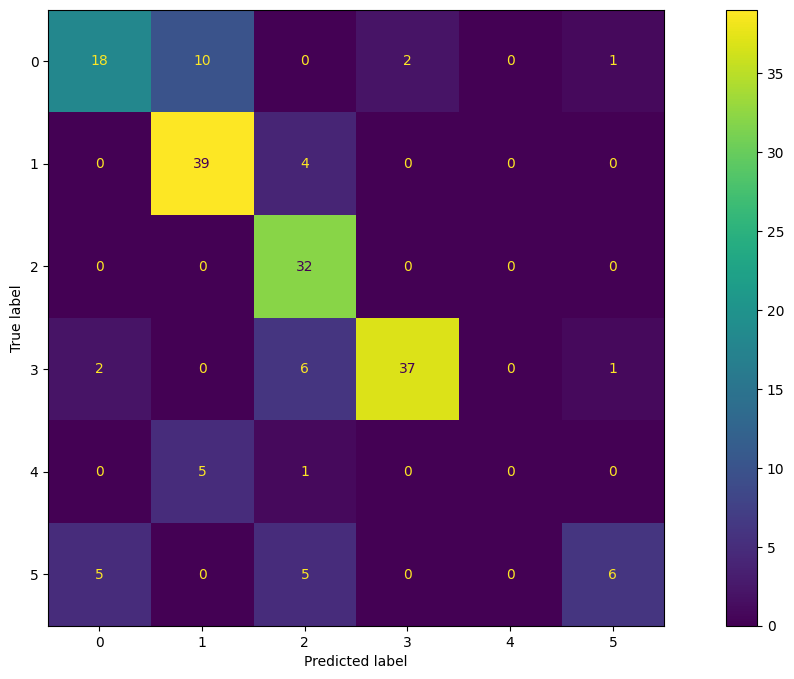

In [50]:
gscv = GridSearchCV(Pipeline([("ovrlogreg", MyOneVsRestLogRegClassifier())]),
                    {"ovrlogreg__epoches" : [50, 100],
                     "ovrlogreg__batch_size" : [5, 10],
                     "ovrlogreg__SGD_step" : [1, 0.5, 0.1]})
gscv.fit(train_X, train_y)
scores(gscv, test_X, test_y)

Логистическая регрессия - [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Лучшие гиперпараметры модели: {'logreg__penalty': 'none', 'logreg__solver': 'newton-cg'}
Лучший счёт модели: 0.876464542651593
Метрика Accuracy: 0.9137931034482759


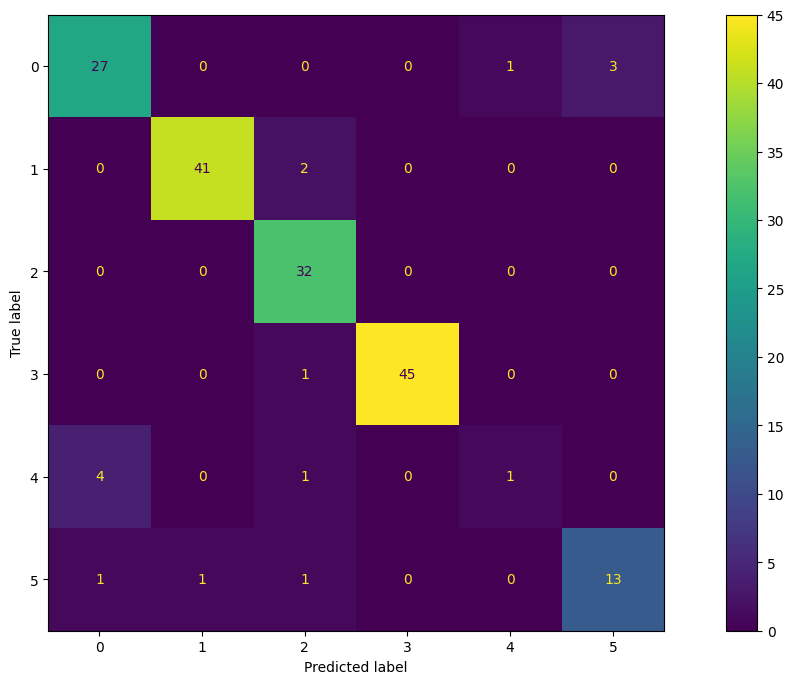

In [51]:
gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression() )]),
                    {"logreg__penalty" : ["l2", "none"],
                     "logreg__solver" : ["newton-cg"]})
gscv.fit(train_X, train_y)
scores(gscv, test_X, test_y)

Логистическая регрессия из sklearn показала более точные результаты